In [94]:
import torch
import torchvision
import torchvision.transforms as transforms

In [95]:
device = torch.device("mps")

In [96]:
import random

# 랜덤 시드 고정 함수
def set_random_seed(seed):
    torch.manual_seed(seed)  # PyTorch CPU 시드 고정
    torch.mps.manual_seed(seed)
    np.random.seed(seed)     # NumPy 시드 고정
    random.seed(seed)        # Python random 시드 고정

# 시드 설정
SEED = 32
set_random_seed(SEED)

## [MY CODE] Dataset 및 activation 함수 변경 (1/2)

In [97]:
# 데이터셋 전처리
transform = transforms.Compose([
    transforms.ToTensor(),                # 이미지를 Tensor로 변환 (픽셀 값을 [0, 1] 범위로 정규화)
    transforms.Normalize((0.5,), (0.5,))  # 정규화: 평균 0.5, 표준편차 0.5로 이미지 값을 [-1, 1]로 스케일 조정
])

batch_size = 256

# CIFAR10 훈련 데이터셋 로드
train_set = torchvision.datasets.CIFAR10(
    root='./data',
    train=True,
    download=True,
    transform=transform,
)

# CIFAR10 학습 데이터 로더
train_loader = torch.utils.data.DataLoader(
    train_set,
    batch_size=batch_size,
    shuffle=True
)

# CIFAR10 테스트 데이터셋 로드
test_set = torchvision.datasets.CIFAR10(
    root='./data',
    train=False,
    download=True,
    transform=transform,
)

# CIFAR10 테스트 데이터 로더
test_loader = torch.utils.data.DataLoader(
    test_set,
    batch_size=batch_size,
    shuffle=False
)

Files already downloaded and verified
Files already downloaded and verified


## [MY CODE] CIFAR10의 입력 shape 확인

In [98]:
from matplotlib import pyplot as plt
import numpy as np

print(len(train_set))
print(type(train_set))
print(train_set.data.shape)
print(train_set[0][0].shape, train_set[0][1])
print(len(np.unique(train_set.targets)))

50000
<class 'torchvision.datasets.cifar.CIFAR10'>
(50000, 32, 32, 3)
torch.Size([3, 32, 32]) 6
10


In [99]:
dataiter = iter(train_loader)
images, labels = next(dataiter)
print(images.shape, labels.shape)

torch.Size([256, 3, 32, 32]) torch.Size([256])


1. 이미지의 Shape: torch.Size([256, 3, 32, 32])
 - 256: 배치 크기(batch size). 한 번에 256개의 이미지를 가져옵니다.
 - 채널 수(channel). 이미지가 RGB 컬러 이미지이므로 3개의 채널이 있습니다.
 - 32: 이미지의 높이(height). 32픽셀입니다.
 - 32: 이미지의 너비(width). 32픽셀입니다.
images는 256개의 RGB 이미지로, 각 이미지의 크기는 32x32 픽셀입니다.

2. 레이블의 Shape: torch.Size([256])
 - 256: 배치 크기와 동일합니다.
 - 각 레이블은 해당 이미지의 클래스 인덱스(정수값)를 나타냅니다.




## [MY CODE] Dataset 및 activation 함수 변경 (2/2)

In [100]:
from torch import nn


class Model(nn.Module):
    def __init__(self, activation, input_dim, num_dim, num_classes):
        super().__init__()

        self.layer1 = nn.Linear(input_dim, num_dim)
        self.layer2 = nn.Linear(num_dim, num_dim)
        self.layer3 = nn.Linear(num_dim, num_classes)  # 최종 출력 레이어

        self.act = activation()

    def forward(self, x):
        x = torch.flatten(x, start_dim=1)  # 입력 평탄화
        x = self.act(self.layer1(x))       # 첫 번째 레이어 + Activation
        x = self.act(self.layer2(x))       # 두 번째 레이어 + Activation
        x = self.layer3(x)                 # 세 번째 레이어 (로짓 반환)
        return x

In [101]:
## [MY CODE] SGD와 Adam 성능 비교

In [102]:
def accuracy(model, dataloader):
  cnt = 0
  acc = 0

  for data in dataloader:
    inputs, labels = data
    inputs, labels = inputs.to(device), labels.to(device)

    preds = model(inputs)
    preds = torch.argmax(preds, dim=-1)

    cnt += labels.shape[0]
    acc += (labels == preds).sum().item()

  return acc / cnt

def plot_acc(train_accuracies, test_accuracies, label1='train', label2='test'):
  x = np.arange(len(train_accuracies))

  plt.plot(x, train_accuracies, label=label1)
  plt.plot(x, test_accuracies, label=label2)
  plt.legend()
  plt.show()

In [103]:
import torch.optim as optim

lr = 0.001
num_epochs = 50

# 손실 함수: 교차 엔트로피 손실 (분류 문제에서 사용)
criterion = nn.CrossEntropyLoss()

train_accuracies = []
test_accuracies = []

In [104]:
### SGD

In [105]:
import time

model = Model(nn.LeakyReLU, 3 * 32 * 32, 1024, 10)
model = model.to(device)

optimizer = optim.SGD(model.parameters(), lr=lr)

for epoch in range(num_epochs):
  start_time = time.time()  # 에포크 시작 시간 기록
  total_loss = 0.
  model.train()  # 학습 모드

  for data in train_loader:
    model.zero_grad()
    inputs, labels = data
    inputs, labels = inputs.to(device), labels.to(device)

    preds = model(inputs)
    loss = criterion(preds, labels)
    loss.backward()
    optimizer.step()

    total_loss += loss.item()

  end_time = time.time()
  epoch_time = end_time - start_time  # 에포크 실행 시간 계산

  with torch.no_grad():
    model.eval()  # 평가 모드
    train_acc = accuracy(model, train_loader)  # 학습 데이터 정확도
    test_acc = accuracy(model, test_loader)    # 테스트 데이터 정확도

  train_accuracies.append(train_acc)
  test_accuracies.append(test_acc)

  print(f"Epoch {epoch+1:3d} |"
        f" Time: {epoch_time:.2f} seconds |"
        f" Loss: {total_loss:.2f} |"
        f" Train Acc: {train_acc:.3f} |"
        f" Test Acc: {test_acc:.3f}")

Epoch   1 | Time: 4.39 seconds | Loss: 450.36 | Train Acc: 0.156 | Test Acc: 0.158
Epoch   2 | Time: 4.29 seconds | Loss: 446.87 | Train Acc: 0.207 | Test Acc: 0.209
Epoch   3 | Time: 4.34 seconds | Loss: 443.41 | Train Acc: 0.227 | Test Acc: 0.232
Epoch   4 | Time: 4.30 seconds | Loss: 439.91 | Train Acc: 0.236 | Test Acc: 0.242
Epoch   5 | Time: 4.37 seconds | Loss: 436.35 | Train Acc: 0.243 | Test Acc: 0.248
Epoch   6 | Time: 4.30 seconds | Loss: 432.67 | Train Acc: 0.248 | Test Acc: 0.255
Epoch   7 | Time: 4.28 seconds | Loss: 428.89 | Train Acc: 0.253 | Test Acc: 0.262
Epoch   8 | Time: 4.28 seconds | Loss: 425.14 | Train Acc: 0.258 | Test Acc: 0.267
Epoch   9 | Time: 4.29 seconds | Loss: 421.41 | Train Acc: 0.263 | Test Acc: 0.271
Epoch  10 | Time: 4.31 seconds | Loss: 417.84 | Train Acc: 0.266 | Test Acc: 0.274
Epoch  11 | Time: 4.40 seconds | Loss: 414.52 | Train Acc: 0.271 | Test Acc: 0.278
Epoch  12 | Time: 4.36 seconds | Loss: 411.12 | Train Acc: 0.277 | Test Acc: 0.281
Epoc

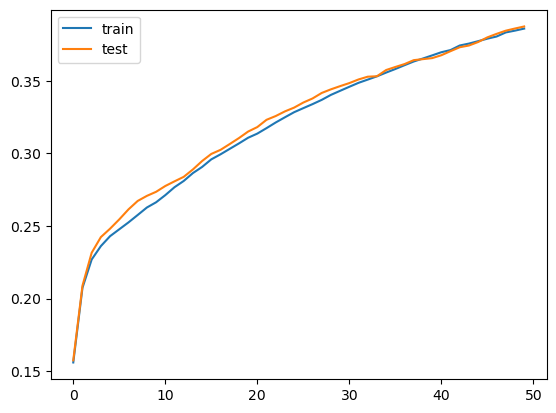

In [106]:
plot_acc(train_accuracies, test_accuracies)

### Adam

In [107]:
model = Model(nn.LeakyReLU, 3 * 32 * 32, 1024, 10)
model = model.to(device)

# 손실 함수: 교차 엔트로피 손실 (분류 문제에서 사용)
criterion = nn.CrossEntropyLoss()

# Adam 옵티마이저 설정
optimizer = optim.Adam(model.parameters(), lr=lr)

train_accuracies = []
test_accuracies = []

for epoch in range(num_epochs):
  start_time = time.time()  # 에포크 시작 시간 기록
  total_loss = 0.
  model.train()  # 학습 모드

  for data in train_loader:
    model.zero_grad()
    inputs, labels = data
    inputs, labels = inputs.to(device), labels.to(device)

    preds = model(inputs)
    loss = criterion(preds, labels)
    loss.backward()
    optimizer.step()

    total_loss += loss.item()

  end_time = time.time()
  epoch_time = end_time - start_time  # 에포크 실행 시간 계산

  with torch.no_grad():
    model.eval()  # 평가 모드
    train_acc = accuracy(model, train_loader)  # 학습 데이터 정확도
    test_acc = accuracy(model, test_loader)    # 테스트 데이터 정확도

  train_accuracies.append(train_acc)
  test_accuracies.append(test_acc)

  print(f"Epoch {epoch+1:3d} |"
        f" Time: {epoch_time:.2f} seconds |"
        f" Loss: {total_loss:.2f} |"
        f" Train Acc: {train_acc:.3f} |"
        f" Test Acc: {test_acc:.3f}")

Epoch   1 | Time: 5.35 seconds | Loss: 318.50 | Train Acc: 0.491 | Test Acc: 0.472
Epoch   2 | Time: 5.08 seconds | Loss: 273.78 | Train Acc: 0.556 | Test Acc: 0.511
Epoch   3 | Time: 5.08 seconds | Loss: 248.20 | Train Acc: 0.601 | Test Acc: 0.527
Epoch   4 | Time: 5.08 seconds | Loss: 227.69 | Train Acc: 0.645 | Test Acc: 0.538
Epoch   5 | Time: 5.07 seconds | Loss: 207.26 | Train Acc: 0.681 | Test Acc: 0.547
Epoch   6 | Time: 5.08 seconds | Loss: 187.58 | Train Acc: 0.707 | Test Acc: 0.537
Epoch   7 | Time: 5.10 seconds | Loss: 166.48 | Train Acc: 0.764 | Test Acc: 0.547
Epoch   8 | Time: 5.09 seconds | Loss: 144.94 | Train Acc: 0.792 | Test Acc: 0.538
Epoch   9 | Time: 5.11 seconds | Loss: 126.97 | Train Acc: 0.824 | Test Acc: 0.555
Epoch  10 | Time: 5.13 seconds | Loss: 108.72 | Train Acc: 0.855 | Test Acc: 0.550
Epoch  11 | Time: 5.10 seconds | Loss: 90.43 | Train Acc: 0.877 | Test Acc: 0.543
Epoch  12 | Time: 5.09 seconds | Loss: 79.79 | Train Acc: 0.898 | Test Acc: 0.546
Epoch 

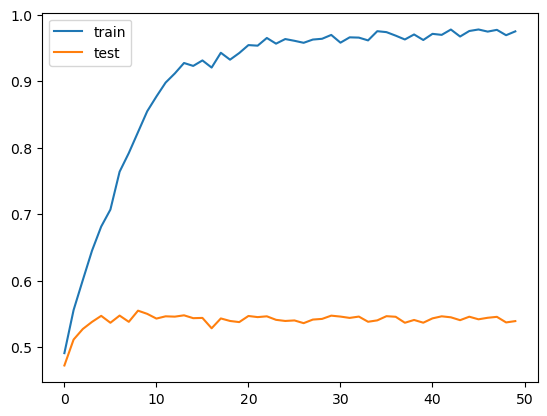

In [108]:
plot_acc(train_accuracies, test_accuracies)

# [MY CODE] Leaky ReLU와 Sigmoid 성능 비교

In [109]:
model = Model(nn.Sigmoid, 3 * 32 * 32, 1024, 10)
model = model.to(device)

# 손실 함수: 교차 엔트로피 손실 (분류 문제에서 사용)
criterion = nn.CrossEntropyLoss()

# Adam 옵티마이저 설정
optimizer = optim.Adam(model.parameters(), lr=lr)

train_accuracies = []
test_accuracies = []

for epoch in range(num_epochs):
  start_time = time.time()  # 에포크 시작 시간 기록
  total_loss = 0.
  model.train()  # 학습 모드

  for data in train_loader:
    model.zero_grad()
    inputs, labels = data
    inputs, labels = inputs.to(device), labels.to(device)

    preds = model(inputs)
    loss = criterion(preds, labels)
    loss.backward()
    optimizer.step()

    total_loss += loss.item()

  end_time = time.time()
  epoch_time = end_time - start_time  # 에포크 실행 시간 계산

  with torch.no_grad():
    model.eval()  # 평가 모드
    train_acc = accuracy(model, train_loader)  # 학습 데이터 정확도
    test_acc = accuracy(model, test_loader)    # 테스트 데이터 정확도

  train_accuracies.append(train_acc)
  test_accuracies.append(test_acc)

  print(f"Epoch {epoch+1:3d} |"
        f" Time: {epoch_time:.2f} seconds |"
        f" Loss: {total_loss:.2f} |"
        f" Train Acc: {train_acc:.3f} |"
        f" Test Acc: {test_acc:.3f}")

Epoch   1 | Time: 5.20 seconds | Loss: 349.80 | Train Acc: 0.429 | Test Acc: 0.425
Epoch   2 | Time: 5.06 seconds | Loss: 304.59 | Train Acc: 0.487 | Test Acc: 0.468
Epoch   3 | Time: 5.03 seconds | Loss: 281.06 | Train Acc: 0.512 | Test Acc: 0.476
Epoch   4 | Time: 5.02 seconds | Loss: 262.76 | Train Acc: 0.559 | Test Acc: 0.498
Epoch   5 | Time: 5.12 seconds | Loss: 244.97 | Train Acc: 0.588 | Test Acc: 0.502
Epoch   6 | Time: 5.03 seconds | Loss: 228.36 | Train Acc: 0.627 | Test Acc: 0.512
Epoch   7 | Time: 5.07 seconds | Loss: 210.63 | Train Acc: 0.668 | Test Acc: 0.515
Epoch   8 | Time: 5.04 seconds | Loss: 192.54 | Train Acc: 0.689 | Test Acc: 0.505
Epoch   9 | Time: 5.04 seconds | Loss: 175.19 | Train Acc: 0.740 | Test Acc: 0.516
Epoch  10 | Time: 5.03 seconds | Loss: 155.68 | Train Acc: 0.750 | Test Acc: 0.511
Epoch  11 | Time: 5.06 seconds | Loss: 139.28 | Train Acc: 0.798 | Test Acc: 0.512
Epoch  12 | Time: 5.03 seconds | Loss: 123.76 | Train Acc: 0.821 | Test Acc: 0.511
Epoc

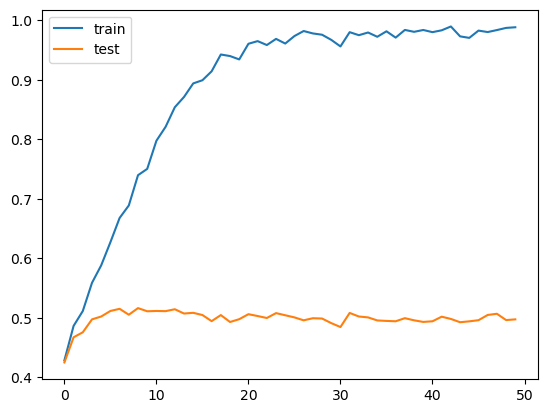

In [110]:
plot_acc(train_accuracies, test_accuracies)

## [MY CODE] Dropout을 적용한 이후의 generalization error 확인

In [111]:
class ModelWithDrop(nn.Module):
    def __init__(self, activation, input_dim, num_dim, num_classes, dropout_prob):
        super().__init__()

        self.layer1 = nn.Linear(input_dim, num_dim)
        self.layer2 = nn.Linear(num_dim, num_dim)
        self.layer3 = nn.Linear(num_dim, num_classes)  # 최종 출력 레이어

        self.act = activation()
        self.dropout = nn.Dropout(p=dropout_prob)  # Dropout 레이어

    def forward(self, x):
        x = torch.flatten(x, start_dim=1)  # 입력 평탄화
        x = self.act(self.layer1(x))       # 첫 번째 레이어 + Activation
        x = self.dropout(x)
        x = self.act(self.layer2(x))       # 두 번째 레이어 + Activation
        x = self.dropout(x)
        x = self.layer3(x)                 # 세 번째 레이어 (로짓 반환)
        return x

In [112]:
model = ModelWithDrop(nn.LeakyReLU, 3 * 32 * 32, 1024, 10, 0.1)
model = model.to(device)

# 손실 함수: 교차 엔트로피 손실 (분류 문제에서 사용)
criterion = nn.CrossEntropyLoss()

# Adam 옵티마이저 설정
optimizer = optim.Adam(model.parameters(), lr=lr)

train_accuracies = []
test_accuracies = []

for epoch in range(num_epochs):
  start_time = time.time()  # 에포크 시작 시간 기록
  total_loss = 0.
  model.train()  # 학습 모드

  for data in train_loader:
    model.zero_grad()
    inputs, labels = data
    inputs, labels = inputs.to(device), labels.to(device)

    preds = model(inputs)
    loss = criterion(preds, labels)
    loss.backward()
    optimizer.step()

    total_loss += loss.item()

  end_time = time.time()
  epoch_time = end_time - start_time  # 에포크 실행 시간 계산

  with torch.no_grad():
    model.eval()  # 평가 모드
    train_acc = accuracy(model, train_loader)  # 학습 데이터 정확도
    test_acc = accuracy(model, test_loader)    # 테스트 데이터 정확도

  train_accuracies.append(train_acc)
  test_accuracies.append(test_acc)

  print(f"Epoch {epoch+1:3d} |"
        f" Time: {epoch_time:.2f} seconds |"
        f" Loss: {total_loss:.2f} |"
        f" Train Acc: {train_acc:.3f} |"
        f" Test Acc: {test_acc:.3f}")

Epoch   1 | Time: 5.35 seconds | Loss: 322.63 | Train Acc: 0.480 | Test Acc: 0.472
Epoch   2 | Time: 5.12 seconds | Loss: 281.80 | Train Acc: 0.540 | Test Acc: 0.494
Epoch   3 | Time: 5.13 seconds | Loss: 258.69 | Train Acc: 0.570 | Test Acc: 0.506
Epoch   4 | Time: 5.16 seconds | Loss: 240.55 | Train Acc: 0.608 | Test Acc: 0.517
Epoch   5 | Time: 5.11 seconds | Loss: 224.92 | Train Acc: 0.657 | Test Acc: 0.540
Epoch   6 | Time: 5.11 seconds | Loss: 208.43 | Train Acc: 0.693 | Test Acc: 0.545
Epoch   7 | Time: 5.20 seconds | Loss: 193.80 | Train Acc: 0.708 | Test Acc: 0.532
Epoch   8 | Time: 5.14 seconds | Loss: 178.15 | Train Acc: 0.751 | Test Acc: 0.547
Epoch   9 | Time: 5.16 seconds | Loss: 164.16 | Train Acc: 0.785 | Test Acc: 0.550
Epoch  10 | Time: 5.17 seconds | Loss: 150.31 | Train Acc: 0.807 | Test Acc: 0.557
Epoch  11 | Time: 5.17 seconds | Loss: 138.65 | Train Acc: 0.832 | Test Acc: 0.548
Epoch  12 | Time: 5.15 seconds | Loss: 125.12 | Train Acc: 0.855 | Test Acc: 0.556
Epoc

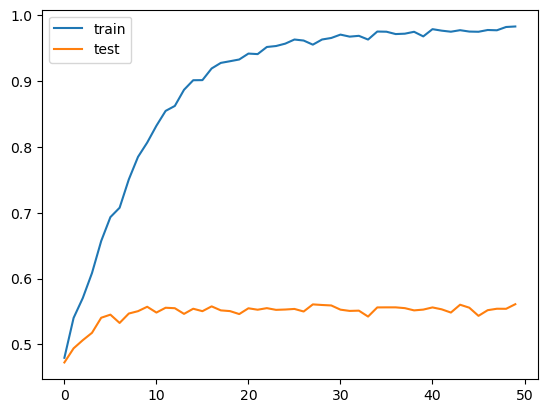

In [113]:
plot_acc(train_accuracies, test_accuracies)